In [7]:
import pandas as pd
import geopandas as gpd # For loading the map of road segments
from shapely.geometry import Point, Polygon
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [17]:
def flaten(centers_list):
    """flatening the list of tuples [(x0,y0),(x1,y1),(x2,y2),(x3,y3)] to [x0,y0,x1,y1,x2,y2,x3,y3]"""
    merged = list(zip(centers_list[:,0],centers_list[:,1]))
    return [c for couple in merged for c in couple ]

In [2]:
# Load the data
data_train = pd.read_csv('../Data/data_train_limited.csv', parse_dates=['datetime'])
data_train.head()

,uid,datetime,latitude,longitude,date,time,day_of_week,month,year
0,1,2018-01-01 00:25:46,-1.188850,36.931382,2018-01-01,00:25:46,Monday,January,2018
1,4,2018-01-01 03:04:01,-1.288087,36.826583,2018-01-01,03:04:01,Monday,January,2018
2,5,2018-01-01 03:58:49,-1.188850,36.931382,2018-01-01,03:58:49,Monday,January,2018
3,7,2018-01-01 05:31:17,-1.165228,36.960008,2018-01-01,05:31:17,Monday,January,2018
4,8,2018-01-01 07:57:56,-1.301303,36.820903,2018-01-01,07:57:56,Monday,January,2018


In [14]:
# View the submission format
ss = pd.read_csv('../Data/SampleSubmission.csv', parse_dates=['date'])
ss.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-07-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-07-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


### Clustering per days

In [15]:
list_day = data_train['day_of_week'].unique()

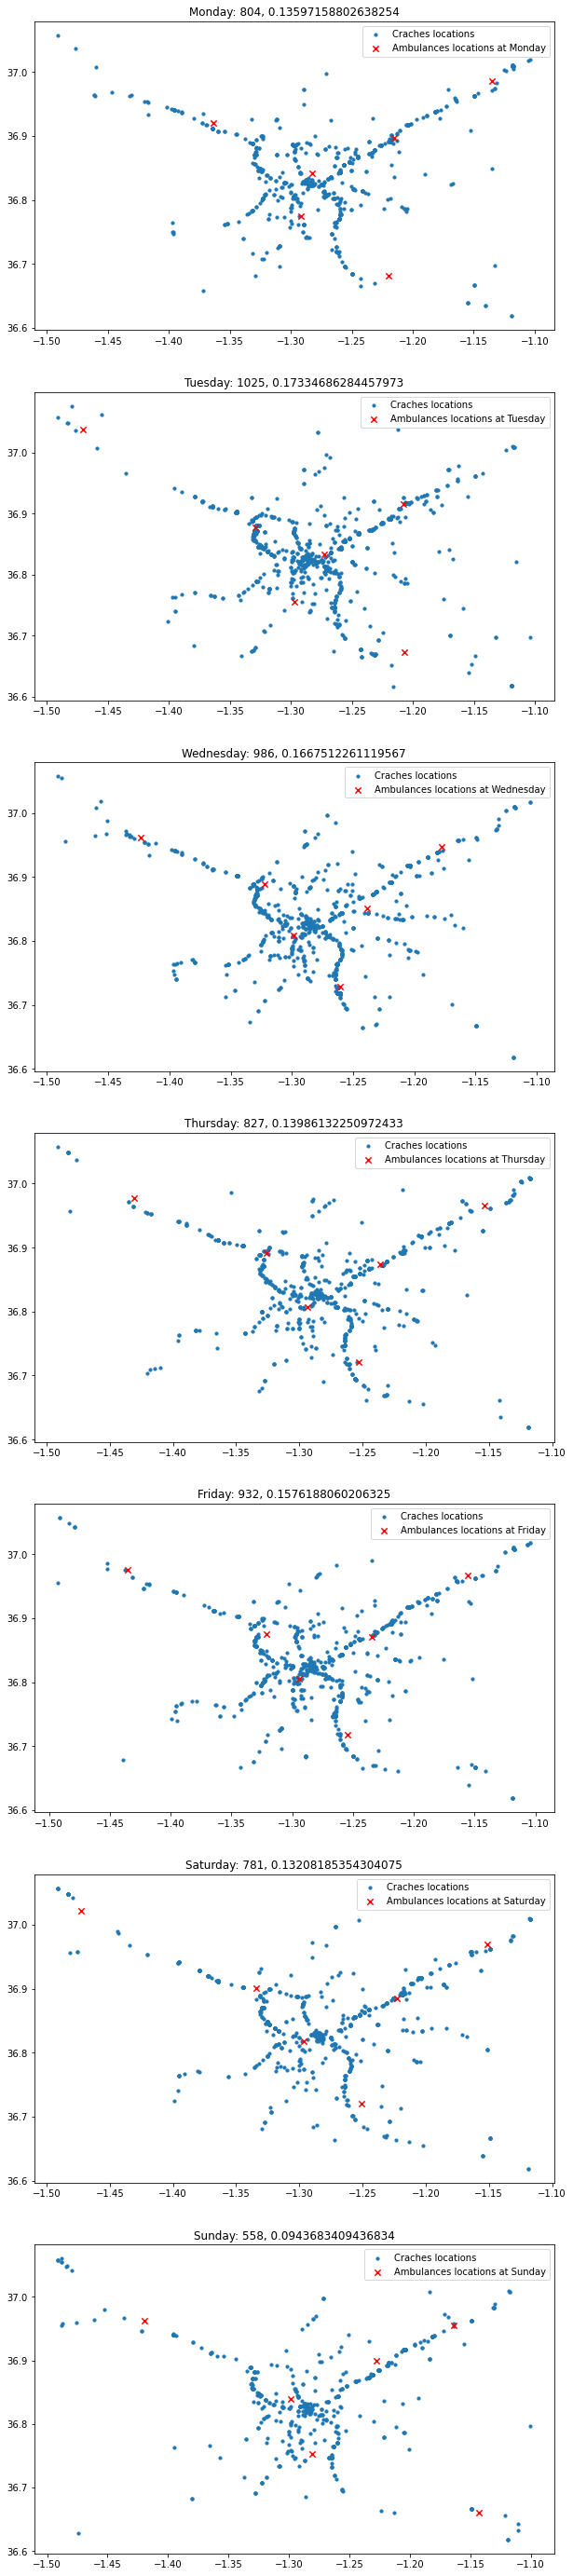

In [42]:
fig, axes = plt.subplots(7, 1, figsize=(10, 50))
l, m = 0, 0
for day in list_day:
    d = data_train[(data_train['day_of_week'] == day)]
    kmeans = KMeans(n_clusters = 6, random_state=500).fit(d[['latitude','longitude']])
    t = flaten(kmeans.cluster_centers_)
    ss.loc[(ss['date'].dt.day_name() == day), ['A0_Latitude','A0_Longitude','A1_Latitude','A1_Longitude','A2_Latitude','A2_Longitude','A3_Latitude','A3_Longitude','A4_Latitude','A4_Longitude','A5_Latitude','A5_Longitude']] = t
    axes[m].scatter(x = d['latitude'],y=d['longitude'],s=10, label='Craches locations')
    axes[m].set_title(str(day) + ': ' + str(len(d)) + ', ' + str(len(d)/len(data_train)))
    axes[m].scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1],marker="x", color='r',label='Ambulances locations at '+str(day),s=40)
    axes[m].legend()
    m += 1
plt.show()

In [45]:
ss.to_csv('../Data/Submit/kmeans_limited_day.csv', index=False)

### Clustering per days and hours

In [46]:
list_day = data_train['day_of_week'].unique()

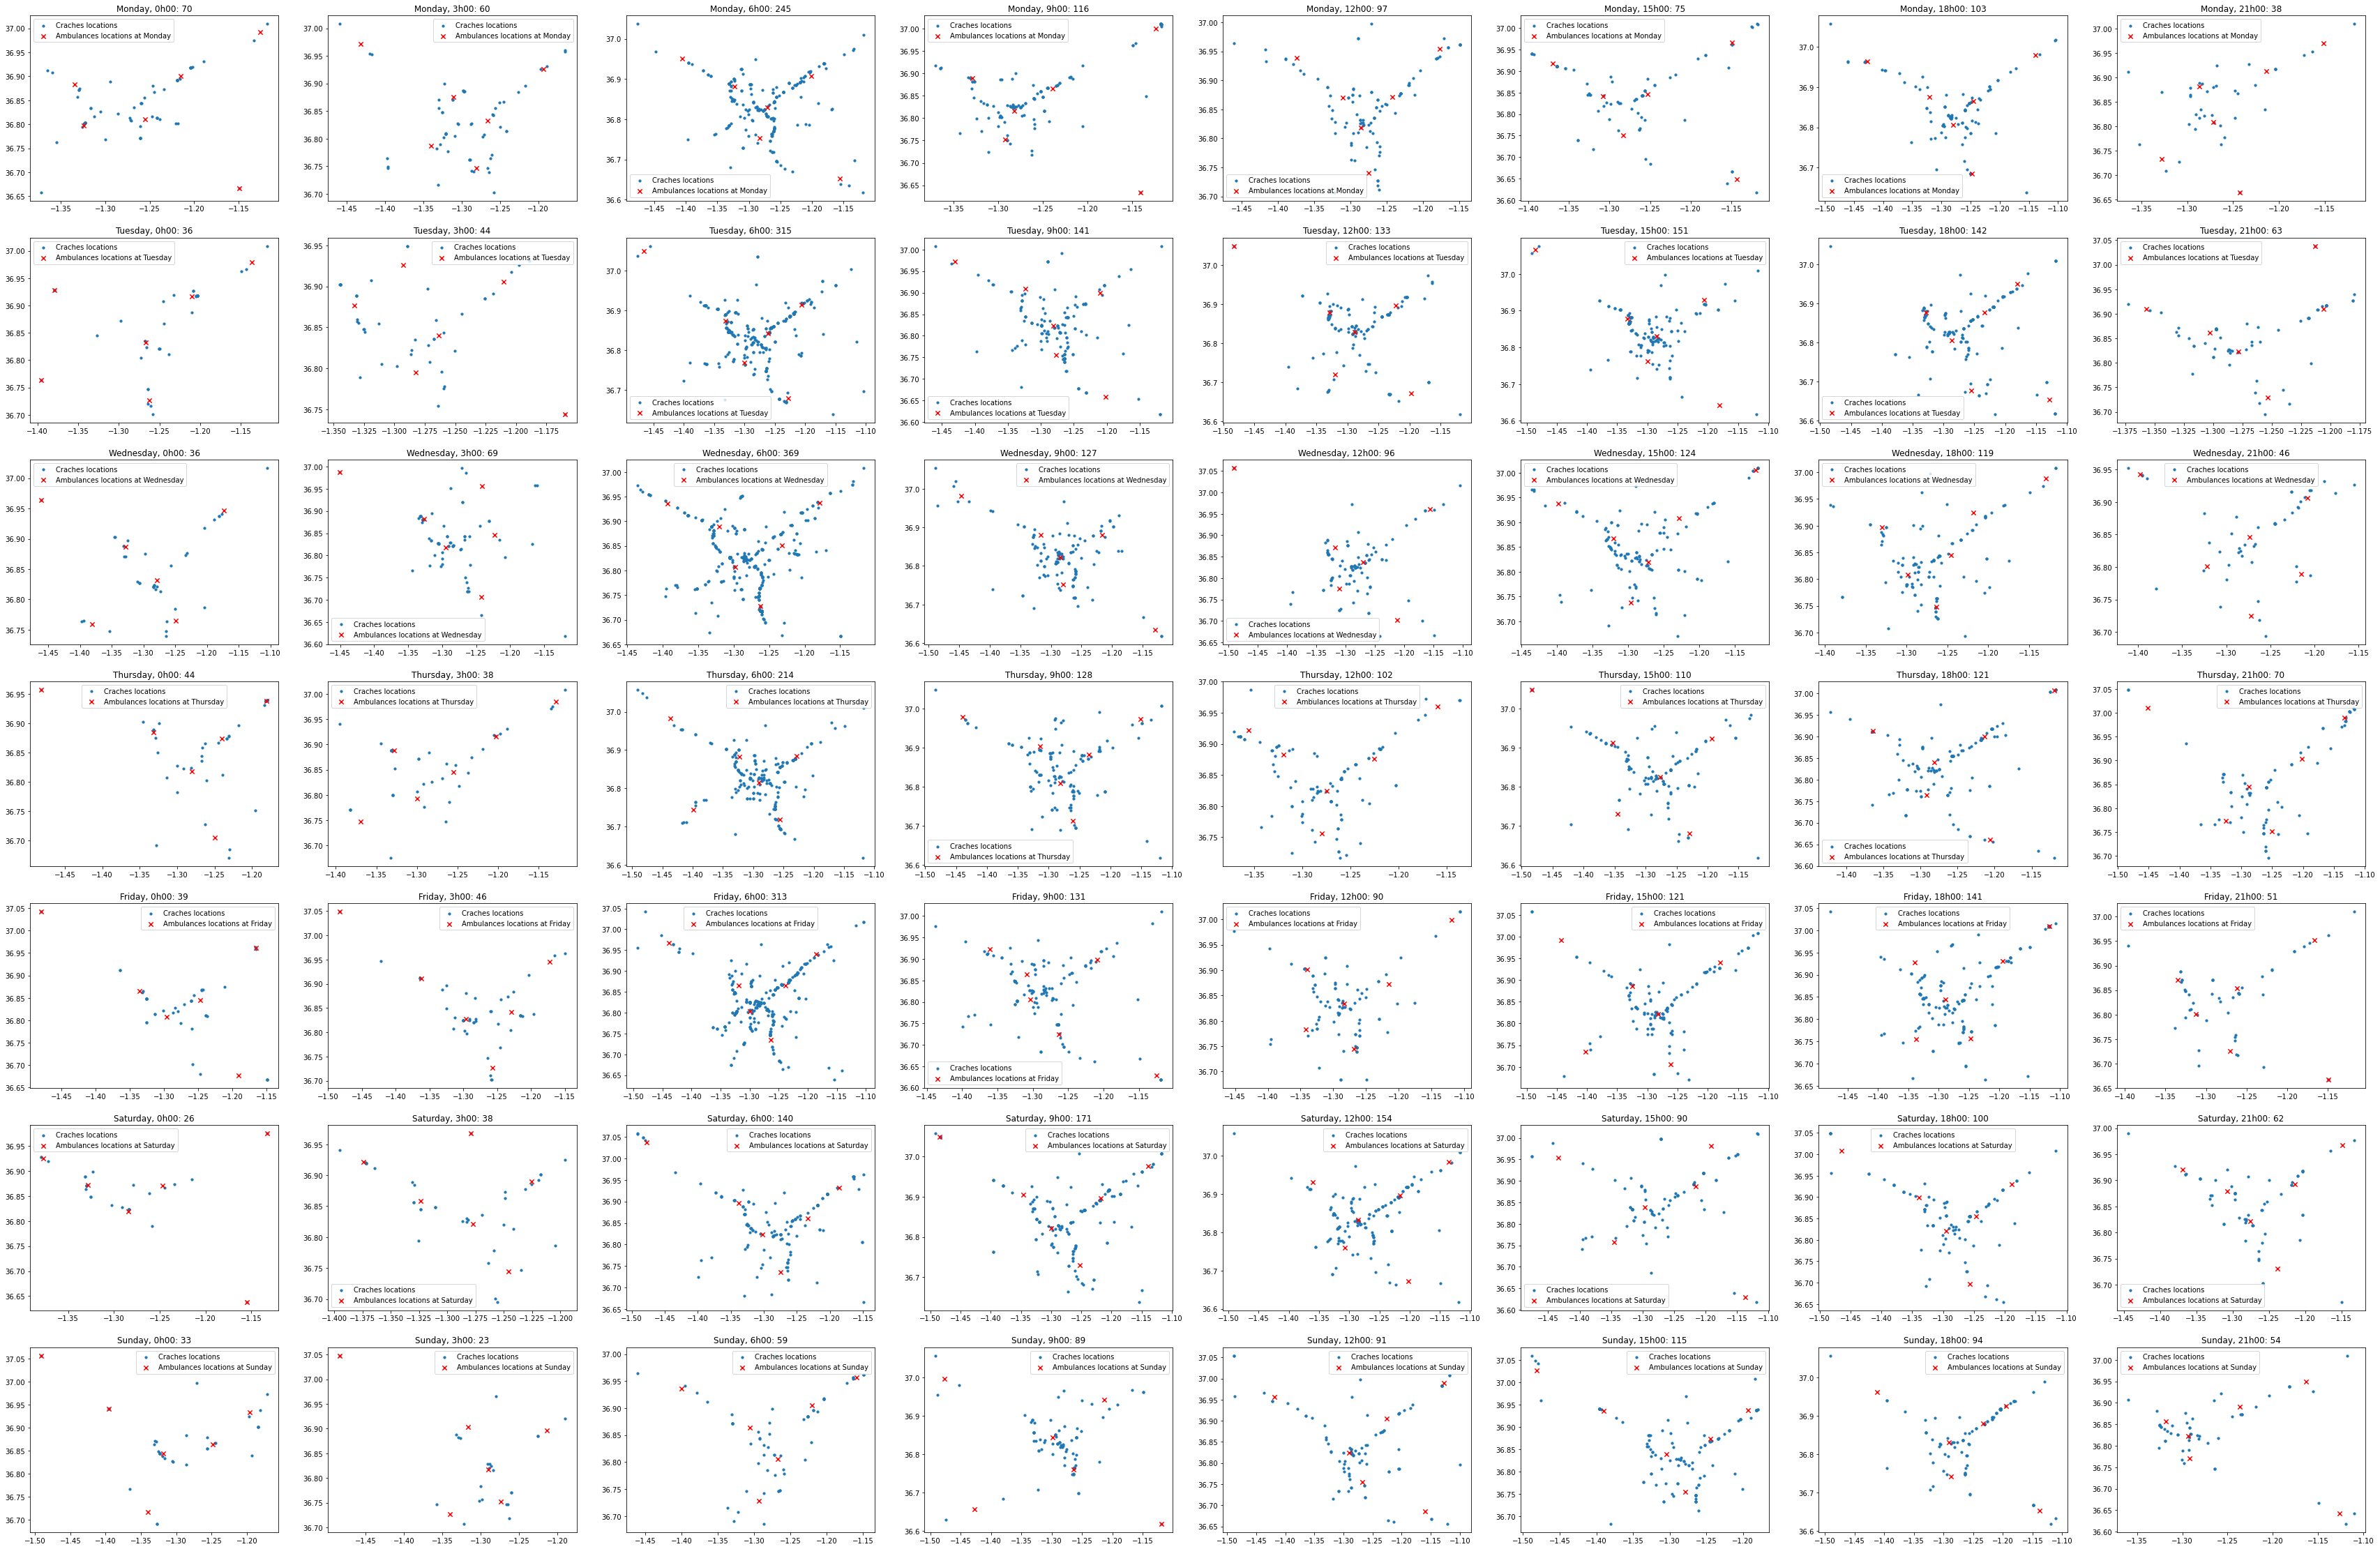

In [57]:
fig, axes = plt.subplots(7, 8, figsize=(60, 40))
l, m = 0, 0
for day in list_day:
    for i in range(0, 22, 3):
        d = data_train[(data_train['day_of_week'] == day) & (data_train['datetime'].dt.hour>=i) & (data_train['datetime'].dt.hour<i+3)]
        kmeans = KMeans(n_clusters = 6, random_state=500).fit(d[['latitude','longitude']])
        #t = flaten(kmeans.cluster_centers_)
        #ss.loc[(ss['date'].dt.day_name() == day), ['A0_Latitude','A0_Longitude','A1_Latitude','A1_Longitude','A2_Latitude','A2_Longitude','A3_Latitude','A3_Longitude','A4_Latitude','A4_Longitude','A5_Latitude','A5_Longitude']] = t
        axes[l,m].scatter(x = d['latitude'],y=d['longitude'],s=10, label='Craches locations')
        axes[l,m].set_title(str(day) + ', ' + str(i) +'h00: ' + str(len(d)))
        axes[l,m].scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1],marker="x", color='r',label='Ambulances locations at '+str(day),s=40)
        axes[l,m].legend()
        m += 1
    m = 0
    l += 1
plt.show()

### Considering [Monday, Tuesday, Wednesday, Thursday, Friday] and [Saturday, Sunday]

In [59]:
list_of_day = ['Normal_day', 'Week_end']
list_normal_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
list_week_end = ['Saturday', 'Sunday']
data_temp = data_train.copy()
data_temp.loc[data_temp['day_of_week'].isin(list_normal_day), 'day_of_week'] = 'Normal_day'
data_temp.loc[data_temp['day_of_week'].isin(list_week_end), 'day_of_week'] = 'Week_end'
data_temp['day_of_week'].unique()

array(['Normal_day', 'Week_end'], dtype=object)

In [66]:
def map_normal_week_end(day_name):
    list_normal_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    list_week_end = ['Saturday', 'Sunday']
    if day_name in list_normal_day:
        return 'Normal_day'
    else:
        return 'Week_end'

In [68]:
ss['date'].dt.day_name().apply(map_normal_week_end).unique()

array(['Normal_day', 'Week_end'], dtype=object)

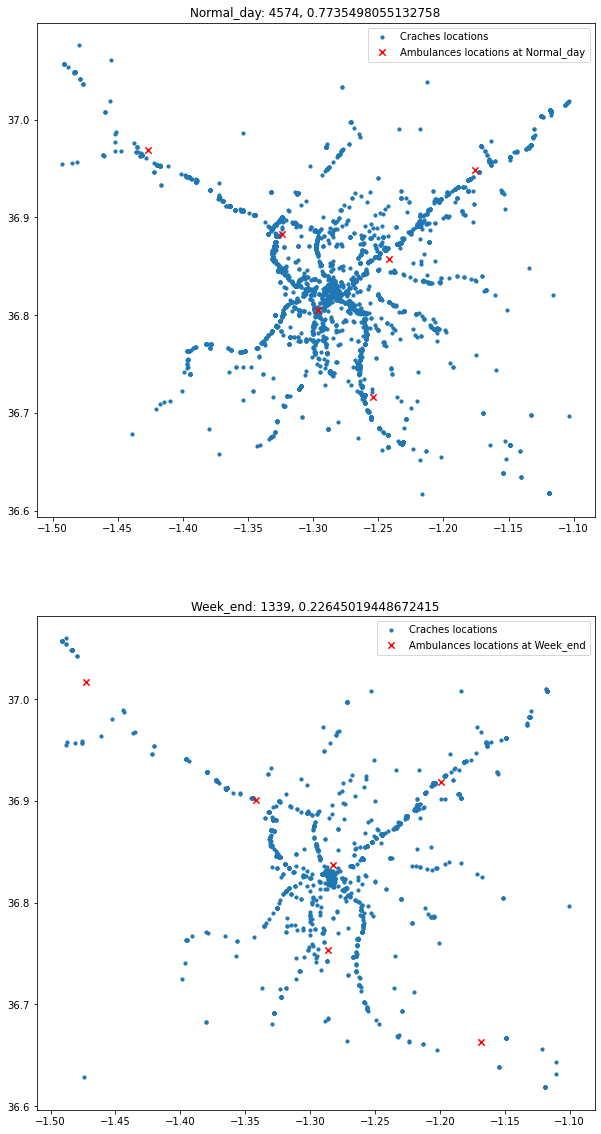

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(10, 20))
l, m = 0, 0
for day in list_of_day:
    d = data_temp[(data_temp['day_of_week'] == day)]
    kmeans = KMeans(n_clusters = 6, random_state=500).fit(d[['latitude','longitude']])
    t = flaten(kmeans.cluster_centers_)
    ss.loc[(ss['date'].dt.day_name().apply(map_normal_week_end) == day), ['A0_Latitude','A0_Longitude','A1_Latitude','A1_Longitude','A2_Latitude','A2_Longitude','A3_Latitude','A3_Longitude','A4_Latitude','A4_Longitude','A5_Latitude','A5_Longitude']] = t
    axes[m].scatter(x = d['latitude'],y=d['longitude'],s=10, label='Craches locations')
    axes[m].set_title(str(day) + ': ' + str(len(d)) + ', ' + str(len(d)/len(data_temp)))
    axes[m].scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1],marker="x", color='r',label='Ambulances locations at '+str(day),s=40)
    axes[m].legend()
    m += 1
plt.show()

### Constat: 
- 77.35% des données sont dans Normal day
- 22.65 des données sont dans Week_end

In [70]:
ss.to_csv('../Data/Submit/kmeans_2_day_type.csv', index=False)

### Considering [Monday, Tuesday, Wednesday, Thursday, Friday] and [Saturday, Sunday] and divide hours per 3 intervals

In [71]:
list_of_day = ['Normal_day', 'Week_end']
list_normal_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
list_week_end = ['Saturday', 'Sunday']
data_temp = data_train.copy()
data_temp.loc[data_temp['day_of_week'].isin(list_normal_day), 'day_of_week'] = 'Normal_day'
data_temp.loc[data_temp['day_of_week'].isin(list_week_end), 'day_of_week'] = 'Week_end'
data_temp['day_of_week'].unique()

array(['Normal_day', 'Week_end'], dtype=object)

In [72]:
def map_normal_week_end(day_name):
    list_normal_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    list_week_end = ['Saturday', 'Sunday']
    if day_name in list_normal_day:
        return 'Normal_day'
    else:
        return 'Week_end'

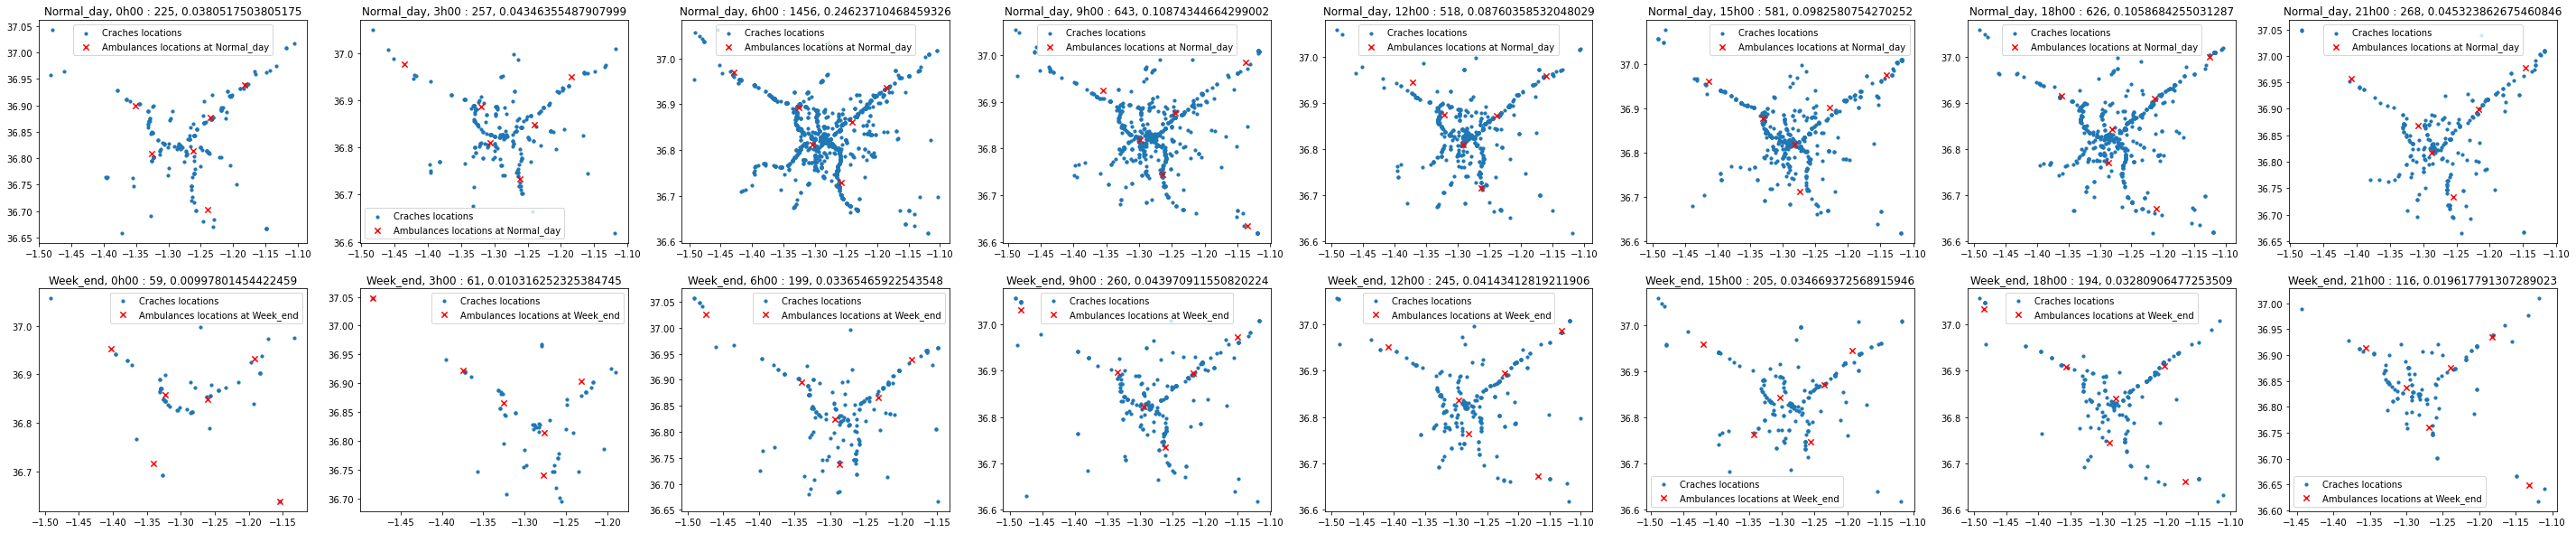

In [78]:
fig, axes = plt.subplots(2, 8, figsize=(50, 10))
l, m = 0, 0
for day in list_of_day:
    for i in range(0, 22, 3):
        d = data_temp[(data_temp['day_of_week'] == day) & (data_train['datetime'].dt.hour>=i) & (data_train['datetime'].dt.hour<i+3)]
        kmeans = KMeans(n_clusters = 6, random_state=500).fit(d[['latitude','longitude']])
        t = flaten(kmeans.cluster_centers_)
        ss.loc[(ss['date'].dt.day_name().apply(map_normal_week_end) == day) & (ss['date'].dt.hour>=i) & (ss['date'].dt.hour<i+3), ['A0_Latitude','A0_Longitude','A1_Latitude','A1_Longitude','A2_Latitude','A2_Longitude','A3_Latitude','A3_Longitude','A4_Latitude','A4_Longitude','A5_Latitude','A5_Longitude']] = t
        axes[l,m].scatter(x = d['latitude'],y=d['longitude'],s=10, label='Craches locations')
        axes[l,m].set_title(str(day) + ', ' + str(i) + 'h00 : ' + str(len(d)) + ', ' + str(len(d)/len(data_temp)))
        axes[l,m].scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1],marker="x", color='r',label='Ambulances locations at '+str(day),s=40)
        axes[l,m].legend()
        m += 1
    m = 0
    l += 1
plt.show()

In [79]:
ss.to_csv('../Data/Submit/kmeans_2_day_type_and_hour.csv', index=False)